Celda 1: Importación de Librerías Necesarias


In [59]:
# Celda 1: Importación de Librerías Necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
import traceback

print("Librerías importadas.")

Librerías importadas.


Celda 2: Carga de Datasets Originales (X e y)


In [60]:
x_file_path = "/content/X_processed_dataset_26features.csv"
try:
    X_df_original = pd.read_csv(x_file_path, engine='python', on_bad_lines='warn')
    print(f"Dataset de características '{x_file_path}' cargado exitosamente.")
    print(f"Dimensiones de X_df_original: {X_df_original.shape}")
    if X_df_original.empty:
        print("ADVERTENCIA: El DataFrame X_df_original está vacío después de la carga.")
except FileNotFoundError:
    print(f"ERROR: Archivo '{x_file_path}' no encontrado. Verifica la ruta.")
    X_df_original = pd.DataFrame()
except Exception as e:
    print(f"ERROR al cargar o parsear '{x_file_path}': {e}")
    X_df_original = pd.DataFrame()

y_file_path = "/content/y_target_dataset.csv"
try:
    y_df_original = pd.read_csv(y_file_path)
    if not y_df_original.empty and y_df_original.shape[1] == 1:
        y_series_original = y_df_original.iloc[:, 0]
        print(f"Dataset de variable objetivo '{y_file_path}' cargado exitosamente.")
        print(f"Dimensiones originales de y_series_original: {y_series_original.shape}")
    elif not y_df_original.empty:
        print(f"ADVERTENCIA: El archivo y '{y_file_path}' tiene más de una columna. Se usará la primera.")
        y_series_original = y_df_original.iloc[:, 0]
        print(f"Dimensiones originales de y_series_original: {y_series_original.shape}")
    else:
        print(f"ERROR: El archivo y '{y_file_path}' está vacío o no se pudo cargar correctamente.")
        y_series_original = pd.Series(dtype='int')
except FileNotFoundError:
    print(f"ERROR: Archivo '{y_file_path}' no encontrado. Verifica la ruta.")
    y_series_original = pd.Series(dtype='int')
except Exception as e:
    print(f"ERROR al cargar o parsear '{y_file_path}': {e}")
    y_series_original = pd.Series(dtype='int')

X_processed_df = X_df_original.copy()
y = y_series_original.copy()

Dataset de características '/content/X_processed_dataset_26features.csv' cargado exitosamente.
Dimensiones de X_df_original: (100000, 81)
Dataset de variable objetivo '/content/y_target_dataset.csv' cargado exitosamente.
Dimensiones originales de y_series_original: (100000,)


Celda 3: Verificar y Alinear los Datos Cargados

In [61]:
if not X_processed_df.empty and not y.empty:
    print("\nVerificando y alineando X_processed_df e y...")
    if len(X_processed_df) != len(y):
        print(f"Discrepancia en longitud: X tiene {len(X_processed_df)} filas, y tiene {len(y)} filas.")
        min_len = min(len(X_processed_df), len(y))
        print(f"Ajustando ambos DataFrames/Series a la longitud mínima: {min_len}")
        X_processed_df = X_processed_df.iloc[:min_len]
        y = y.iloc[:min_len]
        print(f"Nuevas dimensiones de X_processed_df: {X_processed_df.shape}")
        print(f"Nuevas dimensiones de y: {y.shape}")

    if len(X_processed_df) == len(y):
        print("X e y ahora tienen la misma longitud.")
        y = y.reset_index(drop=True)
        X_processed_df = X_processed_df.reset_index(drop=True)

        print("\nPrimeras 5 filas de X_processed_df (alineado):")
        print(X_processed_df.head())
        print("\nInformación de X_processed_df (alineado):")
        X_processed_df.info(verbose=True, show_counts=True)

        print("\nPrimeras 5 filas de y (alineado):")
        print(y.head())
        print("\nDistribución de y (alineado):")
        print(y.value_counts(normalize=True))

        if X_processed_df.isnull().all().any():
            print("\nADVERTENCIA: Una o más columnas en X_processed_df están completamente vacías (todos NaN) antes del preprocesamiento.")
            print(X_processed_df.isnull().all()[X_processed_df.isnull().all()])
    else:
        print(f"ERROR: X ({len(X_processed_df)} filas) e y ({len(y)} filas) aún no coinciden en longitud después del intento de alineación.")
        X_processed_df = pd.DataFrame()
else:
    print("\nNo se pudieron cargar X o y correctamente. Omitiendo el resto del script.")
    X_processed_df = pd.DataFrame()


Verificando y alineando X_processed_df e y...
X e y ahora tienen la misma longitud.

Primeras 5 filas de X_processed_df (alineado):
      price  base_price  initial_quantity  sold_quantity  available_quantity  \
0 -0.788907   -0.788022         -0.080967      -0.056155           -0.080422   
1  1.199043    1.198656         -0.080967      -0.056155           -0.080422   
2 -0.950517   -0.949528         -0.080967      -0.056155           -0.080422   
3  0.333968    0.334135         -0.080967      -0.056155           -0.080422   
4 -1.336274   -1.335039         -0.080967      -0.056155           -0.080422   

   listing_type_id_bronze  listing_type_id_free  listing_type_id_gold  \
0                    True                 False                 False   
1                   False                 False                 False   
2                    True                 False                 False   
3                   False                 False                 False   
4                    

Celda 4: Preprocesamiento Adicional de Características con ColumnTransformer


In [62]:
if not X_df_original.empty:
    print("\n--- Preprocesamiento Adicional de Características con ColumnTransformer ---")

    text_cols = ['title']
    other_object_cols = [col for col in X_df_original.select_dtypes(include='object').columns if col not in text_cols]
    numeric_and_bool_cols = [col for col in X_df_original.select_dtypes(exclude='object').columns]


    print(f"Columnas de texto para TF-IDF: {text_cols}")
    print(f"Columnas objeto no-texto (para OneHotEncoding): {other_object_cols}")
    print(f"Columnas numéricas/booleanas: {numeric_and_bool_cols}")

    text_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='_na_placeholder_')),
        ('caster', FunctionTransformer(lambda x: x[:, 0].astype(str), feature_names_out='one-to-one')),
        ('tfidf', TfidfVectorizer(max_features=100, stop_words=None, token_pattern=r"(?u)\b\w+\b"))
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=10))
    ])

    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ])

    numeric_pipeline_scaled = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    base_transformers = []
    if text_cols:
        for col_name in text_cols:
             base_transformers.append((f'text_{col_name}', text_pipeline, [col_name]))
    if other_object_cols:
        base_transformers.append(('categorical_features', categorical_pipeline, other_object_cols))

    transformers_for_ct_no_scale = list(base_transformers)
    if numeric_and_bool_cols:
        transformers_for_ct_no_scale.append(('numeric_features', numeric_pipeline, numeric_and_bool_cols))

    transformers_for_ct_scaled = list(base_transformers)
    if numeric_and_bool_cols:
        transformers_for_ct_scaled.append(('numeric_features_scaled', numeric_pipeline_scaled, numeric_and_bool_cols))

    preprocessor_ct_no_scale = None
    if transformers_for_ct_no_scale:
        preprocessor_ct_no_scale = ColumnTransformer(
            transformers=transformers_for_ct_no_scale, remainder='drop', verbose_feature_names_out=False)
        print("Preprocessor (sin escalado numérico) definido.")

    preprocessor_ct_scaled = None
    if transformers_for_ct_scaled:
        preprocessor_ct_scaled = ColumnTransformer(
            transformers=transformers_for_ct_scaled, remainder='drop', verbose_feature_names_out=False)
        print("Preprocessor (con escalado numérico) definido.")

    X_processed_df = pd.DataFrame()
    if preprocessor_ct_no_scale:
        print("\nAplicando ColumnTransformer (sin escalado numérico) a X_df_original...")
        try:
            X_temp_matrix = preprocessor_ct_no_scale.fit_transform(X_df_original.copy())
            feature_names_out = preprocessor_ct_no_scale.get_feature_names_out()
            X_processed_df = pd.DataFrame(X_temp_matrix.toarray() if hasattr(X_temp_matrix, "toarray") else X_temp_matrix,
                                          columns=feature_names_out, index=X_df_original.index)
            print(f"Dimensiones de X_processed_df (sin escalado): {X_processed_df.shape}")
            if X_processed_df.isnull().any().any():
                print("ADVERTENCIA: NaNs en X_processed_df.")
            else:
                print("No se encontraron NaNs en X_processed_df.")
            print(f"Tipos de datos en X_processed_df:\n{X_processed_df.dtypes.value_counts()}")
        except Exception as e:
            print(f"Error en ColumnTransformer (sin escalado): {e}")
            traceback.print_exc()
            X_processed_df = pd.DataFrame()

    X_processed_df_scaled = pd.DataFrame()
    if preprocessor_ct_scaled:
        print("\nAplicando ColumnTransformer (CON escalado numérico) a X_df_original...")
        try:
            X_scaled_matrix = preprocessor_ct_scaled.fit_transform(X_df_original.copy())
            feature_names_out_scaled = preprocessor_ct_scaled.get_feature_names_out()
            X_processed_df_scaled = pd.DataFrame(X_scaled_matrix.toarray() if hasattr(X_scaled_matrix, "toarray") else X_scaled_matrix,
                                                 columns=feature_names_out_scaled, index=X_df_original.index)
            print(f"Dimensiones de X_processed_df_scaled: {X_processed_df_scaled.shape}")
            if X_processed_df_scaled.isnull().any().any():
                 print("ADVERTENCIA: NaNs en X_processed_df_scaled.")
            else:
                 print("No se encontraron NaNs en X_processed_df_scaled.")
            print(f"Tipos de datos en X_processed_df_scaled:\n{X_processed_df_scaled.dtypes.value_counts()}")
        except Exception as e:
            print(f"Error en ColumnTransformer (con escalado): {e}")
            traceback.print_exc()
            X_processed_df_scaled = pd.DataFrame()
else:
    print("\nX_df_original está vacío. Omitiendo preprocesamiento.")


--- Preprocesamiento Adicional de Características con ColumnTransformer ---
Columnas de texto para TF-IDF: ['title']
Columnas objeto no-texto (para OneHotEncoding): ['warranty', 'tags', 'shipping_methods', 'non_mercado_pago_payment_methods', 'date_created']
Columnas numéricas/booleanas: ['price', 'base_price', 'initial_quantity', 'sold_quantity', 'available_quantity', 'listing_type_id_bronze', 'listing_type_id_free', 'listing_type_id_gold', 'listing_type_id_gold_premium', 'listing_type_id_gold_pro', 'listing_type_id_gold_special', 'listing_type_id_silver', 'buying_mode_auction', 'buying_mode_buy_it_now', 'buying_mode_classified', 'shipping_mode_custom', 'shipping_mode_me1', 'shipping_mode_me2', 'shipping_mode_not_specified', 'status_active', 'status_closed', 'status_not_yet_active', 'status_paused', 'listing_source_', 'international_delivery_mode_none', 'country_', 'country_Argentina', 'state_Buenos Aires', 'state_Capital Federal', 'state_Chubut', 'state_Córdoba', 'state_Entre Ríos', 

Celda 5: División de Datos en Conjuntos de Entrenamiento y Prueba


In [63]:
X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='int'), pd.Series(dtype='int')
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='int'), pd.Series(dtype='int')

if not X_processed_df.empty and not y.empty and len(X_processed_df) == len(y):
    print("\n--- Dividiendo datos (NO ESCALADOS) en conjuntos de entrenamiento y prueba ---")
    y_aligned_for_no_scale = y.iloc[X_processed_df.index]


    object_cols_final_check = X_processed_df.select_dtypes(include='object').columns
    if not object_cols_final_check.empty:
        print(f"ERROR CRÍTICO FINAL: X_processed_df todavía contiene columnas de tipo 'object': {object_cols_final_check.tolist()}")
    elif X_processed_df.isnull().any().any():
        print(f"ERROR CRÍTICO FINAL: X_processed_df contiene NaNs.")
    else:
        print("X_processed_df (no escalado) está limpio. Procediendo a la división.")
        stratify_param = y_aligned_for_no_scale if y_aligned_for_no_scale.nunique() >= 2 else None
        if stratify_param is None and y_aligned_for_no_scale.nunique() < 2 :
             print(f"ADVERTENCIA: La variable objetivo 'y' para datos no escalados tiene {y_aligned_for_no_scale.nunique()} clases únicas. No se puede usar stratify.")

        X_train, X_test, y_train, y_test = train_test_split(
            X_processed_df, y_aligned_for_no_scale, test_size=0.2, random_state=42, stratify=stratify_param
        )
        print("\nDatos (no escalados) divididos exitosamente:")
        print(f"Forma de X_train: {X_train.shape}, X_test: {X_test.shape}")
        print(f"Forma de y_train: {y_train.shape}, y_test: {y_test.shape}")
else:
    print("\nNo se puede realizar la división train-test para datos no escalados (X_processed_df o y vacíos/desalineados).")


--- Dividiendo datos (NO ESCALADOS) en conjuntos de entrenamiento y prueba ---
X_processed_df (no escalado) está limpio. Procediendo a la división.

Datos (no escalados) divididos exitosamente:
Forma de X_train: (80000, 215), X_test: (20000, 215)
Forma de y_train: (80000,), y_test: (20000,)



División para datos ESCALADOS (para MLP)


In [64]:
if not X_processed_df_scaled.empty and not y.empty and len(X_processed_df_scaled) == len(y):
    print("\n--- Dividiendo datos (ESCALADOS) en conjuntos de entrenamiento y prueba ---")
    y_aligned_for_scaled = y.iloc[X_processed_df_scaled.index]

    object_cols_final_check_scaled = X_processed_df_scaled.select_dtypes(include='object').columns
    if not object_cols_final_check_scaled.empty:
        print(f"ERROR CRÍTICO FINAL: X_processed_df_scaled todavía contiene columnas de tipo 'object': {object_cols_final_check_scaled.tolist()}")
    elif X_processed_df_scaled.isnull().any().any():
        print(f"ERROR CRÍTICO FINAL: X_processed_df_scaled contiene NaNs.")
    else:
        print("X_processed_df_scaled está limpio. Procediendo a la división.")
        stratify_param_scaled = y_aligned_for_scaled if y_aligned_for_scaled.nunique() >= 2 else None
        if stratify_param_scaled is None and y_aligned_for_scaled.nunique() < 2 :
             print(f"ADVERTENCIA: La variable objetivo 'y' para datos escalados tiene {y_aligned_for_scaled.nunique()} clases únicas. No se puede usar stratify.")

        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_processed_df_scaled, y_aligned_for_scaled, test_size=0.2, random_state=42, stratify=stratify_param_scaled
        )
        print("\nDatos (escalados) divididos exitosamente:")
        print(f"Forma de X_train_scaled: {X_train_scaled.shape}, X_test_scaled: {X_test_scaled.shape}")
        print(f"Forma de y_train_scaled: {y_train_scaled.shape}, y_test_scaled: {y_test_scaled.shape}")
else:
    print("\nNo se puede realizar la división train-test para datos escalados (X_processed_df_scaled o y vacíos/desalineados).")


--- Dividiendo datos (ESCALADOS) en conjuntos de entrenamiento y prueba ---
X_processed_df_scaled está limpio. Procediendo a la división.

Datos (escalados) divididos exitosamente:
Forma de X_train_scaled: (80000, 215), X_test_scaled: (20000, 215)
Forma de y_train_scaled: (80000,), y_test_scaled: (20000,)


celda 6: Funciones Auxiliares para Entrenamiento y Evaluación


In [65]:
def train_and_evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name="Modelo"):
    """
    Entrena un modelo, realiza predicciones y lo evalúa.
    Devuelve el modelo entrenado y un diccionario con las métricas.
    """
    metrics_results = {
        'model_name': model_name,
        'accuracy': np.nan,
        'macro_precision': np.nan,
        'macro_recall': np.nan,
        'macro_f1-score': np.nan,
        'weighted_precision': np.nan,
        'weighted_recall': np.nan,
        'weighted_f1-score': np.nan
    }

    if X_train_data.empty or y_train_data.empty:
        print(f"\nNo se puede entrenar el {model_name}: los datos de entrenamiento están vacíos.")
        return None, metrics_results

    print(f"\n--- Entrenamiento del {model_name} ---")

    _y_train_data = y_train_data.copy()
    if _y_train_data.dtype == 'object':
        try:
            _y_train_data = _y_train_data.astype(int)
            print(f"y_train_data convertida a tipo int para {model_name}.")
        except ValueError:
            print(f"ERROR: y_train_data no pudo ser convertida a int para {model_name}. El entrenamiento fallará.")
            return None, metrics_results

    if _y_train_data.dtype != 'object':
        print(f"Entrenando {model_name} con parámetros: {model.get_params()}")
        try:
            model.fit(X_train_data, _y_train_data)
            print(f"{model_name} entrenado exitosamente.")
        except Exception as e:
            print(f"Error durante el entrenamiento del {model_name}: {e}")
            traceback.print_exc()
            return None, metrics_results
    else:
        return None, metrics_results

    if X_test_data.empty or y_test_data.empty:
        print(f"\nNo se puede evaluar el {model_name}: los datos de prueba están vacíos.")
        return model, metrics_results

    print(f"\n--- Evaluación del {model_name} ---")
    _y_test_data = y_test_data.copy()
    if _y_test_data.dtype == 'object':
        try:
            _y_test_data = _y_test_data.astype(int)
            print(f"y_test_data convertida a tipo int para evaluación de {model_name}.")
        except ValueError:
            print(f"ERROR: y_test_data no pudo ser convertida a int para evaluación de {model_name}. No se puede evaluar.")
            return model, metrics_results

    if list(X_test_data.columns) != list(X_train_data.columns):
        print(f"ERROR CRÍTICO: Las columnas de X_test_data no coinciden con X_train_data para {model_name}.")
        return model, metrics_results

    y_pred = model.predict(X_test_data)
    accuracy = accuracy_score(_y_test_data, y_pred)
    print(f"\nPrecisión (Accuracy) del {model_name}: {accuracy:.4f}")
    metrics_results['accuracy'] = accuracy

    y_test_int = _y_test_data.astype(int)
    y_pred_int = y_pred.astype(int)

    unique_classes = sorted(np.unique(np.concatenate((y_test_int, y_pred_int))))
    target_names_eval = [f'Clase {i}' for i in unique_classes]

    if len(unique_classes) == 2 and unique_classes == [0, 1]:
        target_names_eval = ['Usado (0)', 'Nuevo (1)']
    elif len(unique_classes) == 1:
        print(f"ADVERTENCIA: Solo se encontró una clase ({unique_classes[0]}) en y_test/y_pred para {model_name}.")

    report_dict = classification_report(y_test_int, y_pred_int, target_names=target_names_eval, zero_division=0, output_dict=True)
    print(f"\nReporte de Clasificación ({model_name}):")
    print(classification_report(y_test_int, y_pred_int, target_names=target_names_eval, zero_division=0)) # Para visualización

    if 'macro avg' in report_dict:
        metrics_results['macro_precision'] = report_dict['macro avg']['precision']
        metrics_results['macro_recall'] = report_dict['macro avg']['recall']
        metrics_results['macro_f1-score'] = report_dict['macro avg']['f1-score']
    if 'weighted avg' in report_dict:
        metrics_results['weighted_precision'] = report_dict['weighted avg']['precision']
        metrics_results['weighted_recall'] = report_dict['weighted avg']['recall']
        metrics_results['weighted_f1-score'] = report_dict['weighted avg']['f1-score']

    print(f"\nMatriz de Confusión ({model_name}):")
    cm_labels = unique_classes if unique_classes else [0,1]
    if len(unique_classes) == 1:
        cm_labels = [unique_classes[0], unique_classes[0] + 1 if unique_classes[0] == 0 else unique_classes[0] -1 ]

    cm = confusion_matrix(y_test_int, y_pred_int, labels=cm_labels)
    print(cm)

    heatmap_xticklabels = target_names_eval
    heatmap_yticklabels = target_names_eval
    if len(unique_classes) == 1:
         if unique_classes[0] == 0:
             heatmap_xticklabels = ['Usado (0)', 'Pred. Ficticia (1)']
             heatmap_yticklabels = ['Real Usado (0)', 'Real Ficticia (1)']
         elif unique_classes[0] == 1:
             heatmap_xticklabels = ['Pred. Ficticia (0)', 'Nuevo (1)']
             heatmap_yticklabels = ['Real Ficticia (0)', 'Real Nuevo (1)']
         else:
             heatmap_xticklabels = [f'Clase {unique_classes[0]}', f'Clase Ficticia {unique_classes[0]+1}']
             heatmap_yticklabels = [f'Clase {unique_classes[0]}', f'Clase Ficticia {unique_classes[0]+1}']
    elif not unique_classes:
        heatmap_xticklabels = ['Clase 0', 'Clase 1']
        heatmap_yticklabels = ['Clase 0', 'Clase 1']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=heatmap_xticklabels,
                yticklabels=heatmap_yticklabels)
    plt.title(f"Matriz de Confusión ({model_name})")
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()

    return model, metrics_results

print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


Celda 7: Modelo - Regresión Logística



--- Entrenamiento del Regresión Logística ---
Entrenando Regresión Logística con parámetros: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Regresión Logística entrenado exitosamente.

--- Evaluación del Regresión Logística ---

Precisión (Accuracy) del Regresión Logística: 0.8451

Reporte de Clasificación (Regresión Logística):
              precision    recall  f1-score   support

   Usado (0)       0.85      0.81      0.83      9248
   Nuevo (1)       0.84      0.88      0.86     10752

    accuracy                           0.85     20000
   macro avg       0.85      0.84      0.84     20000
weighted avg       0.85      0.85      0.84     20000


Matriz de Confusión (Regresión Logística):
[[7450 1798]
 [1300 9452]]


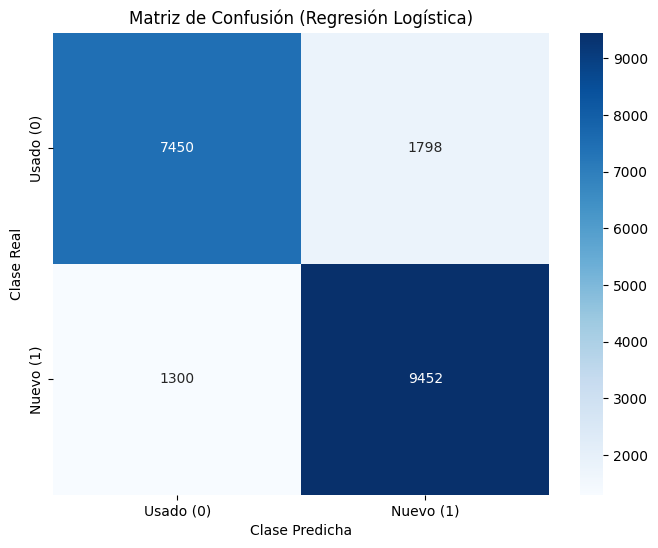


--- Fin del Script (Regresión Logística) ---


In [66]:
all_model_metrics = []

model_lr_instance = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
model_lr, metrics_lr = train_and_evaluate_model(model_lr_instance, X_train, y_train, X_test, y_test, "Regresión Logística")
if model_lr:
    all_model_metrics.append(metrics_lr)

print("\n--- Fin del Script (Regresión Logística) ---")

Celda 8: Modelo - Random Forest Classifier



--- Entrenamiento del RandomForestClassifier ---
Entrenando RandomForestClassifier con parámetros: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
RandomForestClassifier entrenado exitosamente.

--- Evaluación del RandomForestClassifier ---

Precisión (Accuracy) del RandomForestClassifier: 0.8784

Reporte de Clasificación (RandomForestClassifier):
              precision    recall  f1-score   support

   Usado (0)       0.86      0.87      0.87      9248
   Nuevo (1)       0.89      0.88      0.89     10752

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg 

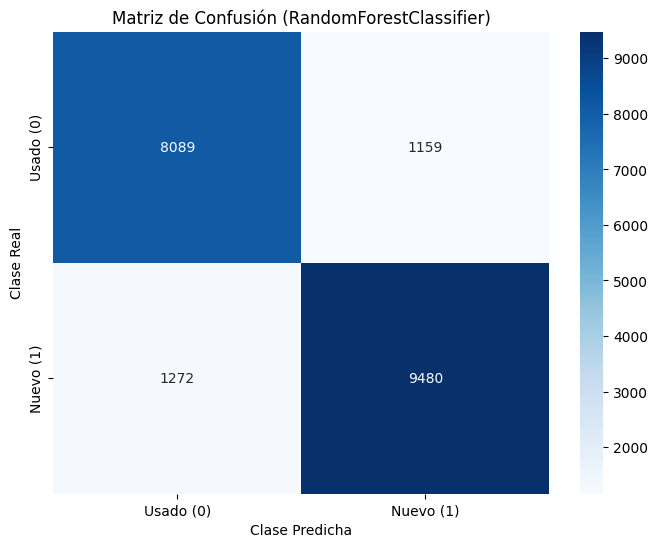


--- Fin del Script (RandomForestClassifier) ---


In [67]:
model_rf_instance = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
)
model_rf, metrics_rf = train_and_evaluate_model(model_rf_instance, X_train, y_train, X_test, y_test, "RandomForestClassifier")
if model_rf:
    all_model_metrics.append(metrics_rf)

print("\n--- Fin del Script (RandomForestClassifier) ---")

Celda 9: Modelo - Gradient Boosting Classifier



--- Entrenamiento del GradientBoostingClassifier ---
Entrenando GradientBoostingClassifier con parámetros: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
GradientBoostingClassifier entrenado exitosamente.

--- Evaluación del GradientBoostingClassifier ---

Precisión (Accuracy) del GradientBoostingClassifier: 0.8571

Reporte de Clasificación (GradientBoostingClassifier):
              precision    recall  f1-score   support

   Usado (0)       0.85      0.84      0.85      9248
   Nuevo (1)       0.87      0.87      0.87     10752

    accuracy                           0.86     20000
   macro avg    

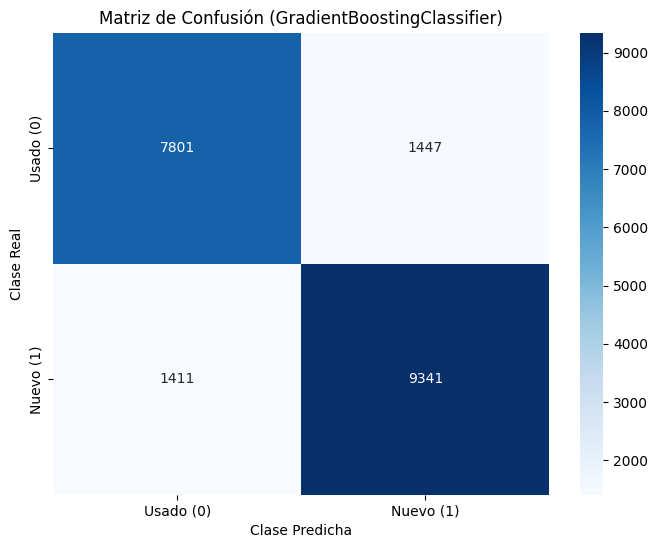


--- Fin del Script (GradientBoostingClassifier) ---


In [68]:
model_gb_instance = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_gb, metrics_gb = train_and_evaluate_model(model_gb_instance, X_train, y_train, X_test, y_test, "GradientBoostingClassifier")
if model_gb:
    all_model_metrics.append(metrics_gb)

print("\n--- Fin del Script (GradientBoostingClassifier) ---")

Celda 10: Modelo - MLP Classifier (Red Neuronal)



--- Entrenamiento del MLPClassifier ---
Entrenando MLPClassifier con parámetros: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
MLPClassifier entrenado exitosamente.

--- Evaluación del MLPClassifier ---

Precisión (Accuracy) del MLPClassifier: 0.8657

Reporte de Clasificación (MLPClassifier):
              precision    recall  f1-score   support

   Usado (0)       0.85      0.86      0.85      9248
   Nuevo (1)       0.88      0.87      0.88     10752

    accuracy                           0.87     20000
   macro avg       0.86      0.86      0.86     2000

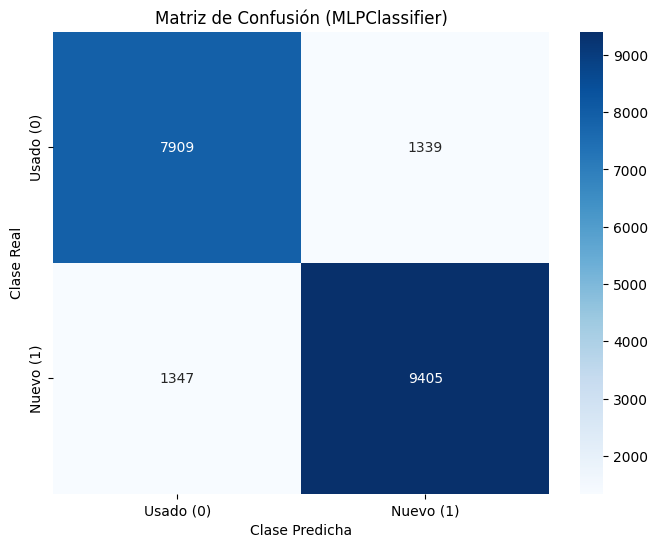


--- Fin del Script (MLPClassifier) ---


In [69]:
model_mlp_instance = None

if not X_train_scaled.empty and not y_train_scaled.empty:
    model_mlp_instance = MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        max_iter=200,
        shuffle=True,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
    model_mlp, metrics_mlp = train_and_evaluate_model(
        model_mlp_instance,
        X_train_scaled, y_train_scaled,
        X_test_scaled, y_test_scaled,
        "MLPClassifier"
    )
    if model_mlp:
        all_model_metrics.append(metrics_mlp)
else:
    print("\nNo se pueden entrenar/evaluar MLPClassifier porque los datos escalados no están disponibles.")
print("\n--- Fin del Script (MLPClassifier) ---")

Celda 11: Tabla Comparativa de Métricas de Modelos


In [70]:
if all_model_metrics:
    metrics_df = pd.DataFrame(all_model_metrics)
    metrics_df.set_index('model_name', inplace=True)

    columns_for_table = {
        'accuracy': 'Accuracy',
        'macro_precision': 'Macro Precision',
        'macro_recall': 'Macro Recall',
        'macro_f1-score': 'Macro F1-Score',
        'weighted_precision': 'Weighted Precision',
        'weighted_recall': 'Weighted Recall',
        'weighted_f1-score': 'Weighted F1-Score'
    }

    existing_cols = [col for col in columns_for_table.keys() if col in metrics_df.columns]
    metrics_display_df = metrics_df[existing_cols].copy()
    metrics_display_df.rename(columns=columns_for_table, inplace=True)

    for col in metrics_display_df.columns:
        metrics_display_df[col] = metrics_display_df[col].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else x)

    print("\n--- Tabla Comparativa de Métricas ---")
    display(metrics_display_df)
else:
    print("\nNo hay métricas de modelos para mostrar en la tabla comparativa.")


--- Tabla Comparativa de Métricas ---


,Accuracy,Macro Precision,Macro Recall,Macro F1-Score,Weighted Precision,Weighted Recall,Weighted F1-Score
model_name,,,,,,,
Regresión Logística,0.8451,0.8458,0.8423,0.8435,0.8454,0.8451,0.8447
RandomForestClassifier,0.8784,0.8776,0.8782,0.8779,0.8786,0.8784,0.8785
GradientBoostingClassifier,0.8571,0.8563,0.8562,0.8562,0.8571,0.8571,0.8571
MLPClassifier,0.8657,0.8649,0.8650,0.8649,0.8657,0.8657,0.8657
